In [2]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [11]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [12]:
!pip install huggingface-hub==0.16.4


   ---------------------------------------- 0.0/268.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/268.8 kB ? eta -:--:--
   ---------- ---------------------------- 71.7/268.8 kB 975.2 kB/s eta 0:00:01
   ------------------------- -------------- 174.1/268.8 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 268.8/268.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.6
    Uninstalling huggingface-hub-0.24.6:
      Successfully uninstalled huggingface-hub-0.24.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [1]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [3]:
from pathlib import Path

# For local file paths (Windows)
data_directory = Path(r'D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\train')

IMAGE_PATH = data_directory / "image"
MASK_PATH = data_directory / "index"

print("image_path:", IMAGE_PATH)



image_path: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\train\image


In [4]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [5]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [6]:
n_classes = 2 # classes of the mask

def create_dataframe():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id':name}, index= np.arange(0, len(name)))

df = create_dataframe()

df

,id
0,BL_BB_19_row1_col5
1,BL_BB_19_row2_col3
2,BL_BB_19_row2_col4
3,BL_BB_19_row2_col6
4,BL_BB_19_row3_col5
...,...
1093,WE_BB_21_row9_col1
1094,WE_BB_21_row9_col2
1095,WE_BB_21_row9_col4
1096,WE_BB_21_row9_col5


In [7]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

Image Path: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\train\image\WE_BB_19_row10_col3.png
Mask Path: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\train\index\WE_BB_19_row10_col3.png


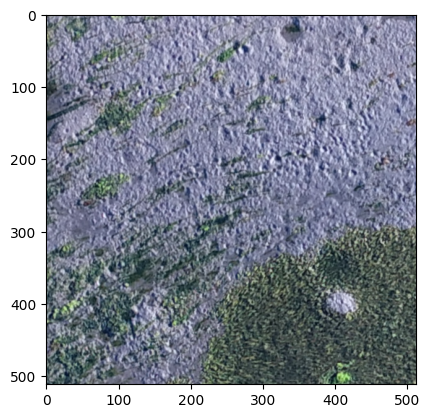

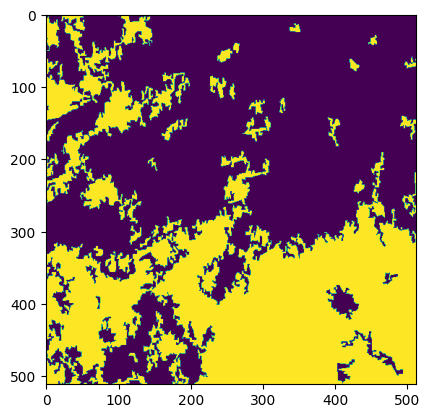

(512, 512, 3)
(512, 512)


In [8]:
for idx in X_val:
    img_path = os.path.join(IMAGE_PATH, idx + '.png')
    mask_path = os.path.join(MASK_PATH, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [9]:
class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [11]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [15]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [16]:
torch.cuda.empty_cache()

In [17]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Thu Aug 29 19:17:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   43C    P8             11W /  170W |     421MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
import os
import torch

# Enable CUDA_LAUNCH_BLOCKING
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Your previous setup code
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# Ensure model is on the correct device
model.to(device)

# Run fit function
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.607 
Epoch:1/20.. Train Loss: 0.691.. Val Loss: 0.607.. Train mIoU:0.402.. Val mIoU: 0.466.. Train Acc:0.579.. Val Acc:0.651.. Time: 3.58m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.607 >> 0.570 
Epoch:2/20.. Train Loss: 0.594.. Val Loss: 0.570.. Train mIoU:0.512.. Val mIoU: 0.511.. Train Acc:0.681.. Val Acc:0.701.. Time: 2.99m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.570 >> 0.539 
Epoch:3/20.. Train Loss: 0.560.. Val Loss: 0.539.. Train mIoU:0.548.. Val mIoU: 0.546.. Train Acc:0.710.. Val Acc:0.717.. Time: 2.95m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.539 >> 0.486 
saving model...
Epoch:4/20.. Train Loss: 0.541.. Val Loss: 0.486.. Train mIoU:0.566.. Val mIoU: 0.575.. Train Acc:0.723.. Val Acc:0.751.. Time: 3.00m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/20.. Train Loss: 0.518.. Val Loss: 0.511.. Train mIoU:0.588.. Val mIoU: 0.576.. Train Acc:0.741.. Val Acc:0.742.. Time: 3.00m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.511 >> 0.456 
Epoch:6/20.. Train Loss: 0.509.. Val Loss: 0.456.. Train mIoU:0.600.. Val mIoU: 0.612.. Train Acc:0.750.. Val Acc:0.772.. Time: 3.01m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.456 >> 0.451 
Epoch:7/20.. Train Loss: 0.491.. Val Loss: 0.451.. Train mIoU:0.615.. Val mIoU: 0.615.. Train Acc:0.763.. Val Acc:0.779.. Time: 3.04m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/20.. Train Loss: 0.493.. Val Loss: 0.489.. Train mIoU:0.610.. Val mIoU: 0.611.. Train Acc:0.759.. Val Acc:0.774.. Time: 3.22m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.489 >> 0.412 
Epoch:9/20.. Train Loss: 0.476.. Val Loss: 0.412.. Train mIoU:0.623.. Val mIoU: 0.657.. Train Acc:0.770.. Val Acc:0.805.. Time: 3.03m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.403 
Epoch:10/20.. Train Loss: 0.462.. Val Loss: 0.403.. Train mIoU:0.636.. Val mIoU: 0.663.. Train Acc:0.780.. Val Acc:0.810.. Time: 2.99m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.403 >> 0.396 
saving model...
Epoch:11/20.. Train Loss: 0.453.. Val Loss: 0.396.. Train mIoU:0.644.. Val mIoU: 0.677.. Train Acc:0.786.. Val Acc:0.818.. Time: 3.01m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:12/20.. Train Loss: 0.461.. Val Loss: 0.456.. Train mIoU:0.633.. Val mIoU: 0.638.. Train Acc:0.779.. Val Acc:0.795.. Time: 2.98m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.456 >> 0.419 
Epoch:13/20.. Train Loss: 0.445.. Val Loss: 0.419.. Train mIoU:0.649.. Val mIoU: 0.657.. Train Acc:0.792.. Val Acc:0.804.. Time: 2.93m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/20.. Train Loss: 0.443.. Val Loss: 0.427.. Train mIoU:0.651.. Val mIoU: 0.650.. Train Acc:0.794.. Val Acc:0.803.. Time: 3.00m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.427 >> 0.411 
Epoch:15/20.. Train Loss: 0.432.. Val Loss: 0.411.. Train mIoU:0.660.. Val mIoU: 0.668.. Train Acc:0.799.. Val Acc:0.809.. Time: 3.02m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.411 >> 0.384 
Epoch:16/20.. Train Loss: 0.428.. Val Loss: 0.384.. Train mIoU:0.661.. Val mIoU: 0.679.. Train Acc:0.801.. Val Acc:0.824.. Time: 2.92m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:17/20.. Train Loss: 0.415.. Val Loss: 0.417.. Train mIoU:0.669.. Val mIoU: 0.655.. Train Acc:0.808.. Val Acc:0.809.. Time: 2.94m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.417 >> 0.399 
Epoch:18/20.. Train Loss: 0.413.. Val Loss: 0.399.. Train mIoU:0.675.. Val mIoU: 0.678.. Train Acc:0.812.. Val Acc:0.822.. Time: 2.93m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Decreasing.. 0.399 >> 0.391 
saving model...
Epoch:19/20.. Train Loss: 0.413.. Val Loss: 0.391.. Train mIoU:0.676.. Val mIoU: 0.681.. Train Acc:0.813.. Val Acc:0.824.. Time: 2.94m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:20/20.. Train Loss: 0.405.. Val Loss: 0.412.. Train mIoU:0.682.. Val mIoU: 0.673.. Train Acc:0.817.. Val Acc:0.819.. Time: 2.87m
Total time: 60.36 m


In [19]:
torch.save(model, 'Unet-mobilenet2-batchsize4-BodegaBay-4.pt')

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

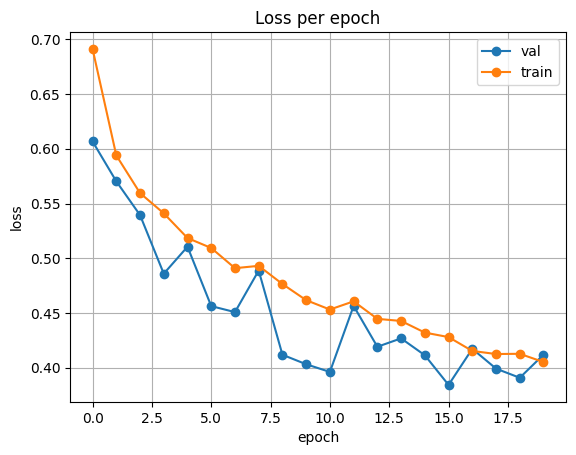

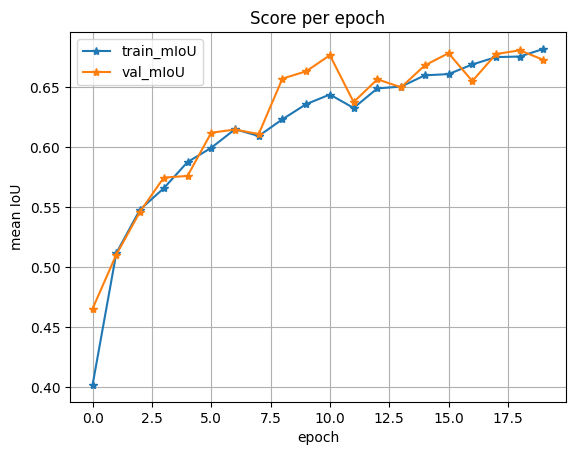

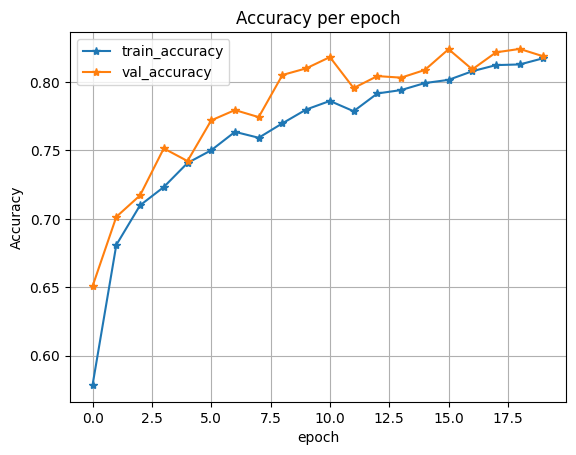

In [21]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [22]:
import torchvision.transforms as transforms

def to_tensor(image):
    return transforms.ToTensor()(image)

In [23]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            # Note: Assuming self.transform can handle NumPy arrays directly
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [24]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [25]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [26]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [27]:
mob_miou = miou_score(model, test_set)
mob_miou

  0%|          | 0/110 [00:00<?, ?it/s]

[0.21420806020096314,
 5.501972457125877e-16,
 0.6349558208992298,
 0.9059510337849829,
 0.978382934164235,
 1.8866643020474078e-16,
 0.397912369719166,
 0.8147488509520683,
 0.021738090846365243,
 0.2928343962125176,
 0.004688740996358008,
 0.7815894911797533,
 0.10667696008905038,
 0.8615410154096586,
 0.9458773934101309,
 0.9962872103298646,
 0.6104102220511578,
 8.665361085596429e-16,
 1.06593898565246e-15,
 0.859424540219668,
 0.7907864783492035,
 0.4674223694549098,
 0.522041123329896,
 0.4378802537638194,
 0.8772178562748116,
 4.970302442903649e-16,
 0.9833693739572604,
 0.8174367097680553,
 0.8248213944333126,
 0.2437766565949865,
 0.7702323050345906,
 0.7483268156465787,
 0.9937946131150661,
 0.33618100832962017,
 0.9983448369591597,
 0.9615401210675263,
 0.18190470279105417,
 0.752238159794971,
 0.37923849586224584,
 0.27393460588311797,
 0.4084193781738222,
 0.7689048345725511,
 3.1604463814469145e-16,
 0.8142032920414051,
 0.7973905527950145,
 0.9988666881881435,
 0.0652160

In [28]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [29]:
mob_acc = pixel_acc(model, test_set)
mob_acc

  0%|          | 0/110 [00:00<?, ?it/s]

[0.08262351707175926,
 0.0,
 0.11558137116608797,
 0.8885904947916666,
 0.8659724482783565,
 0.0,
 0.17204793294270834,
 0.6732109917534722,
 0.0035965530960648147,
 0.1208767361111111,
 0.0009675202546296296,
 0.22004643192997686,
 0.033579508463541664,
 0.7860582139756944,
 0.8754521122685185,
 0.34151430483217593,
 0.4355841742621528,
 0.0,
 0.0,
 0.8250732421875,
 0.10954454210069445,
 0.3671253345630787,
 0.3679210521556713,
 0.129425048828125,
 0.4405721028645833,
 0.0,
 0.2924635145399306,
 0.7734205457899306,
 0.13166865596064814,
 0.13560203269675927,
 0.5407364456741898,
 0.5733800817418981,
 0.9441731770833334,
 0.22256921838831017,
 0.46495451750578703,
 0.42819779007523145,
 0.03974971064814815,
 0.5381051522714121,
 0.04361300998263889,
 0.10001627604166667,
 0.1282676414207176,
 0.42826786747685186,
 0.0,
 0.5423199688946759,
 0.6736472800925926,
 0.8218609845196759,
 0.010433620876736112,
 0.10941116898148148,
 0.1882358127170139,
 0.0034157081886574073,
 0.848854347511

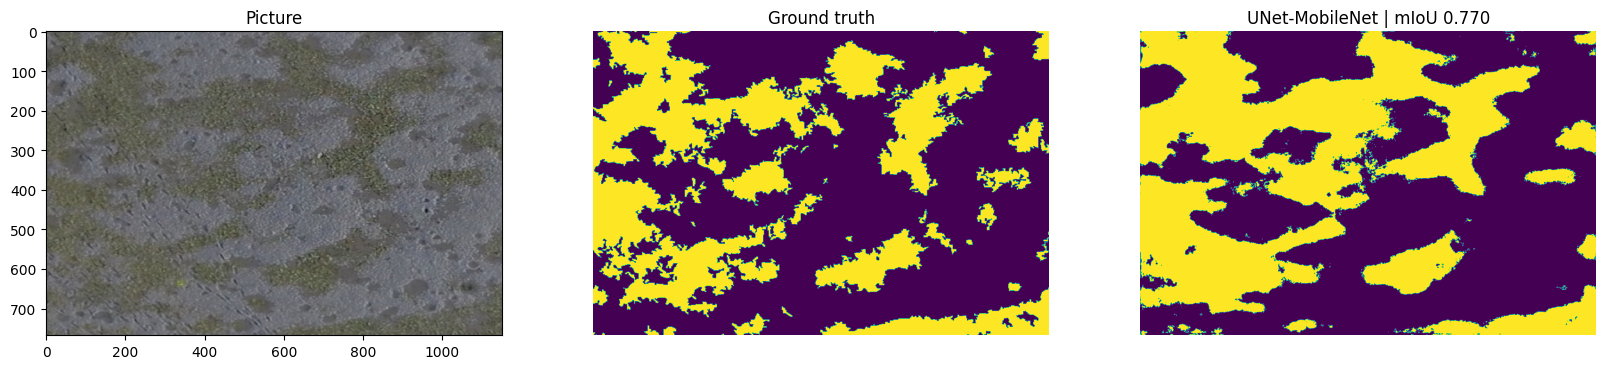

In [48]:
image, mask = test_set[30]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
# Convert torch tensor to numpy array and transpose if necessary

ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

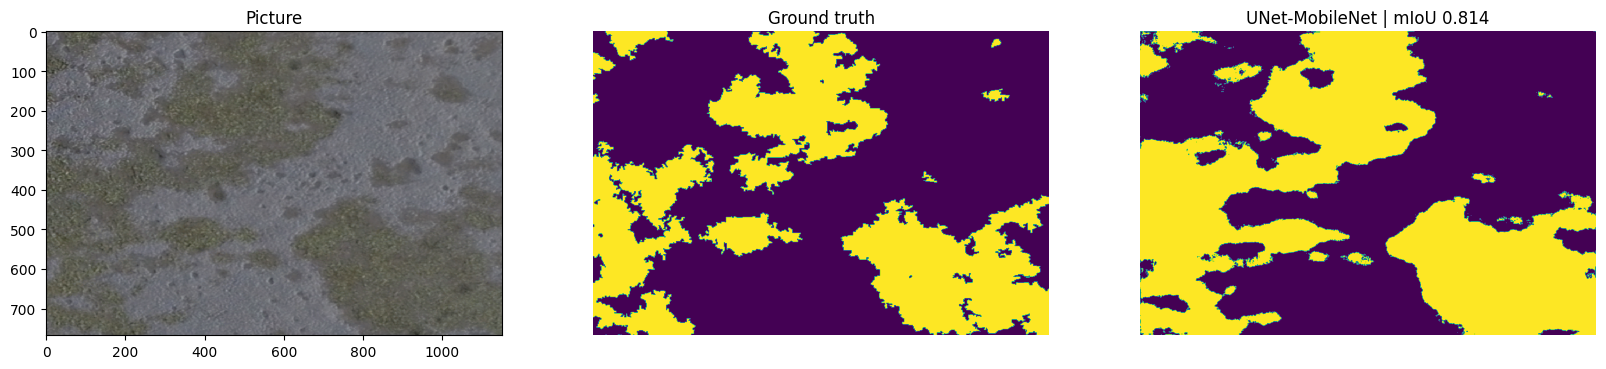

In [31]:
image2, mask2 = test_set[43]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

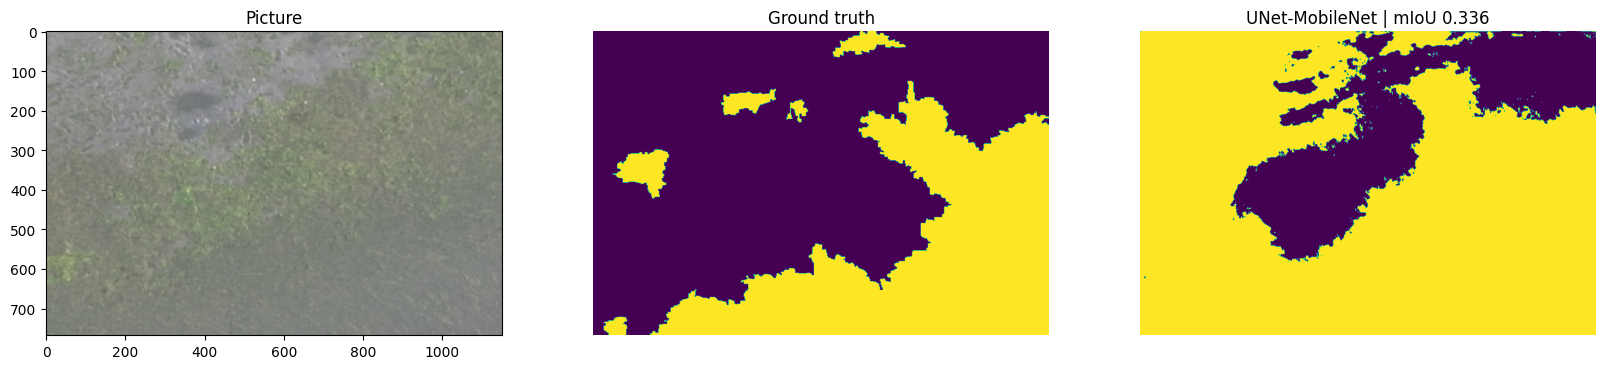

In [32]:
image3, mask3 = test_set[33]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [33]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.555792437854929


In [34]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.32743845724497583
